# Поиск токсичных комментариев(с помощью DistilBert (BERT))

## Загрузка библиотек. Знакомство с данными

In [1]:
import pandas as pd
import numpy as np

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import torch
import transformers
import re
from tqdm import notebook

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

import lightgbm as lgb
import time

from sklearn.metrics import precision_score, recall_score, precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
import seaborn
from sklearn.datasets import make_classification
import warnings
nltk.download('punkt')
nltk.download('stopwords')
warnings.filterwarnings("ignore")

[nltk_data] Error loading punkt: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


Для фиксирования результатов создадим пустые списки

In [2]:
preproces = []
f1_value = []
time_value = []
model_type = []

Загрузим наши данные

In [3]:
# считываем датафрейм
try:
    df=pd.read_csv('C:\\\\Python\\\\ЯП\\\\проект_10\\\\toxic_comments.csv', sep=',')#, parse_dates=[0], index_col=[0])

except:
    df=pd.read_csv('/datasets/toxic_comments.csv', sep=',')#, parse_dates=[0], index_col=[0])

In [4]:
df.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


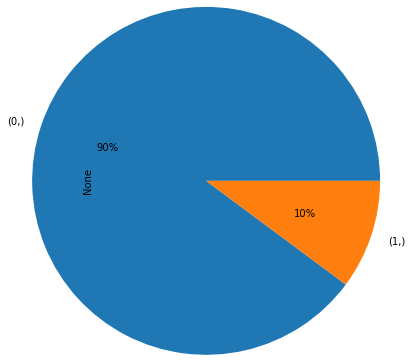

In [5]:
df[['toxic']].value_counts().plot.pie(radius=2, autopct='%1.0f%%');

10% токсичныйх комментов

Проведем предобработку текста. удалим все лишнее

In [6]:
def text_preprocessing(text):
    tokenized = nltk.word_tokenize(text)
    joined = ' '.join(tokenized)
    text_only = re.sub(r'[^a-zA-Z]', ' ', joined)
    final = ' '.join(text_only.split())
    return final

In [7]:
notebook.tqdm.pandas() 
df['text_fin'] = df['text'].progress_apply(text_preprocessing)

In [8]:
df

,text,toxic,text_fin
0,Explanation\nWhy the edits made under my usern...,0,Explanation Why the edits made under my userna...
1,D'aww! He matches this background colour I'm s...,0,D aww He matches this background colour I m se...
2,"Hey man, I'm really not trying to edit war. It...",0,Hey man I m really not trying to edit war It s...
3,"""\nMore\nI can't make any real suggestions on ...",0,More I ca n t make any real suggestions on imp...
4,"You, sir, are my hero. Any chance you remember...",0,You sir are my hero Any chance you remember wh...
...,...,...,...
159566,""":::::And for the second time of asking, when ...",0,And for the second time of asking when your vi...
159567,You should be ashamed of yourself \n\nThat is ...,0,You should be ashamed of yourself That is a ho...
159568,"Spitzer \n\nUmm, theres no actual article for ...",0,Spitzer Umm theres no actual article for prost...
159569,And it looks like it was actually you who put ...,0,And it looks like it was actually you who put ...


Разобьем на обучающую и тестовую выборки:

In [9]:
x_df = df['text_fin']
y_df = df['toxic']
x_train, x_test, y_train, y_test = train_test_split(x_df, y_df, random_state=0, stratify=y_df)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((119678,), (39893,), (119678,), (39893,))

Получение корпуса в кодировке Юникод

In [10]:
x_train_corpus = x_train.values.astype('U')
x_test_corpus = x_test.values.astype('U')

Добавим стоп слова:

In [11]:
stopwords = set(stopwords.words('english'))
stopwords

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

## Предобработка моделей

Попробуем продобработать наши модели разными способами

### Векторизация

In [12]:
vectorizer = CountVectorizer(stop_words=stopwords, dtype=np.float32) 
vectorizer

CountVectorizer(dtype=<class 'numpy.float32'>,
                stop_words={'a', 'about', 'above', 'after', 'again', 'against',
                            'ain', 'all', 'am', 'an', 'and', 'any', 'are',
                            'aren', "aren't", 'as', 'at', 'be', 'because',
                            'been', 'before', 'being', 'below', 'between',
                            'both', 'but', 'by', 'can', 'couldn', "couldn't", ...})

In [13]:
x_train_vectorized = vectorizer.fit_transform(x_train_corpus)
x_test_vectorized = vectorizer.transform(x_test_corpus)

In [14]:
x_train_vectorized

<119678x142722 sparse matrix of type '<class 'numpy.float32'>'
	with 3266265 stored elements in Compressed Sparse Row format>

In [15]:
print(x_train_vectorized.shape)

(119678, 142722)


In [16]:
print(x_train_vectorized[:5].toarray())

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


## Строим модели

### модель LogisticRegression

In [17]:
start_time = time.time()

clf_gs = GridSearchCV(LogisticRegression(max_iter=2000), {}, cv=5, scoring='f1')
notebook.tqdm.pandas() 
clf_gs.fit(x_train_vectorized,y_train)

train_f1_score = f1_score(y_train, clf_gs.predict(x_train_vectorized))
print('train_f1_score = ',train_f1_score)

test_f1_score = f1_score(y_test, clf_gs.predict(x_test_vectorized))
print('train_f1_score = ',test_f1_score)

time_value.append(time.time() - start_time)
f1_value.append(test_f1_score)
model_type.append('LogisticRegression')
preproces.append('CountVectorizer')

train_f1_score =  0.8975916973433271
train_f1_score =  0.759238830667402


train_f1_score =  0.8975916973433271
train_f1_score =  0.759238830667402

### модель LGBMClassifier

In [18]:
start_time = time.time()

clf_lgc = GridSearchCV(lgb.LGBMClassifier(n_estimators = 1000, learning_rate = 0.1), {}, cv=5, scoring='f1')
clf_lgc.fit(x_train_vectorized,y_train)

train_f1_score_1 = f1_score(y_train, clf_lgc.predict(x_train_vectorized))
print('train_f1_score = ',train_f1_score_1)

test_f1_score_1 = f1_score(y_test, clf_lgc.predict(x_test_vectorized))
print('test_f1_score = ', test_f1_score_1)

time_value.append(time.time() - start_time)
f1_value.append(test_f1_score_1)
model_type.append('LGBMClassifier')
preproces.append('CountVectorizer')

train_f1_score =  0.9177254008586699
test_f1_score =  0.7717945186613414


In [19]:
precision_score(y_true=y_test, y_pred=clf_lgc.predict(x_test_vectorized))

0.8742589703588144

In [20]:
recall_score(y_true=y_test, y_pred=clf_lgc.predict(x_test_vectorized))

0.6908284023668639

In [21]:
prec, rec, thresholds=precision_recall_curve(y_true=y_test, probas_pred=clf_lgc.predict_proba(x_test_vectorized)[:,1])


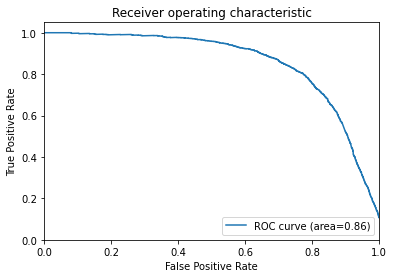

In [22]:


roc_auc=auc(rec, prec)


plt.figure()
plt.plot(rec, prec, label='ROC curve (area=%0.2f)'%(roc_auc))
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc='lower right')

Значения пресижен выше чем значения рекол.
мы будем более осторожны и будем удалять те комментарии, когда мы в них прям очень сильно уверены что они негативные.

### Обработка TF-IDF

In [23]:
tf_idf = TfidfVectorizer(stop_words=stopwords)

In [24]:
x_train_tf_idf = tf_idf.fit_transform(x_train)
x_test_tf_idf = tf_idf.transform(x_test)

In [25]:
print(x_train_tf_idf.shape)

(119678, 142722)


In [26]:
print(x_train_tf_idf[:5].toarray())

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


 ### модель LogisticRegression

In [27]:
start_time = time.time()

clf_gs = GridSearchCV(LogisticRegression(max_iter=2000), {}, cv=5, scoring='f1')
notebook.tqdm.pandas() 
clf_gs.fit(x_train_tf_idf,y_train)

train_f1_score_2 = f1_score(y_train, clf_gs.predict(x_train_tf_idf))
print('train_f1_score = ',train_f1_score_2)

test_f1_score_2 = f1_score(y_test, clf_gs.predict(x_test_tf_idf))
print('train_f1_score = ',test_f1_score_2)

time_value.append(time.time() - start_time)
f1_value.append(test_f1_score_2)
model_type.append('LogisticRegression')
preproces.append('TfidfVectorizer')

train_f1_score =  0.7605438126426516
train_f1_score =  0.7181350287617317


### модель LGBMClassifier

In [28]:
start_time = time.time()

clf_lgc = GridSearchCV(lgb.LGBMClassifier(n_estimators = 1000, learning_rate = 0.1), {}, cv=5, scoring='f1')
clf_lgc.fit(x_train_tf_idf, y_train)

train_f1_score_3 = f1_score(y_train, clf_lgc.predict(x_train_tf_idf))
print('train_f1_score = ',train_f1_score_3)

test_f1_score_4 = f1_score(y_test, clf_lgc.predict(x_test_tf_idf))
print('test_f1_score = ', test_f1_score_4)

time_value.append(time.time() - start_time)
f1_value.append(test_f1_score_4)
model_type.append('LGBMClassifier')
preproces.append('TfidfVectorizer')

train_f1_score =  0.9528419068831113
test_f1_score =  0.77641885392332


##  DistilBert

В виду того что не получается спользовать все данные для обучения, возьмем первые 3000 строк нашего датафрейма

In [29]:
model_class, tokenizer_class, pretrained_weights = (transformers.DistilBertModel,
                                                    transformers.DistilBertTokenizer, 
                                                    'distilbert-base-uncased')

In [31]:
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
tokenizer

PreTrainedTokenizer(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_len=512, is_fast=False, padding_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

In [32]:
model = model_class.from_pretrained(pretrained_weights)
model

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0): TransformerBlock(
        (attention): MultiHeadSelfAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(i

In [33]:
tokenized = df['text_fin'][:3000].progress_apply(lambda x: tokenizer.encode(x[:512], add_special_tokens=True))
tokenized

0       [101, 7526, 2339, 1996, 10086, 2015, 2081, 210...
1       [101, 1040, 22091, 2860, 2002, 3503, 2023, 428...
2       [101, 4931, 2158, 1045, 1049, 2428, 2025, 2667...
3       [101, 2062, 1045, 6187, 1050, 1056, 2191, 2151...
4       [101, 2017, 2909, 2024, 2026, 5394, 2151, 3382...
                              ...                        
2995    [101, 2047, 2930, 2012, 1059, 2361, 2019, 2072...
2996       [101, 1998, 4851, 2327, 2644, 5994, 2033, 102]
2997    [101, 2128, 2035, 5167, 1045, 2113, 2008, 2017...
2998    [101, 2061, 2017, 2025, 2183, 2425, 2033, 2339...
2999    [101, 2198, 10852, 3145, 2141, 2257, 1999, 866...
Name: text_fin, Length: 3000, dtype: object

In [34]:
padded = np.array([i + [0]*(512-len(i)) for i in tokenized.values])
print(padded)
print(len(padded[0]))

[[  101  7526  2339 ...     0     0     0]
 [  101  1040 22091 ...     0     0     0]
 [  101  4931  2158 ...     0     0     0]
 ...
 [  101  2128  2035 ...     0     0     0]
 [  101  2061  2017 ...     0     0     0]
 [  101  2198 10852 ...     0     0     0]]
512


In [35]:
attention_mask = np.where(padded != 0, 1, 0)
attention_mask

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])

In [36]:
padded.shape, attention_mask.shape

((3000, 512), (3000, 512))

In [37]:
batch_size = 20
embeddings = []

In [38]:
for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
    batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)])
    attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])
    
    with torch.no_grad():
        batch_embeddings = model(batch, attention_mask=attention_mask_batch)
    embeddings.append(batch_embeddings[0][:,0,:].numpy())

In [39]:
x_bert = np.concatenate(embeddings)
y_bert = df['toxic'][:3000]
x_bert.shape, y_bert.shape

((3000, 768), (3000,))

In [40]:
x_train_bert, x_test_bert, y_train_bert, y_test_bert = train_test_split(x_bert, y_bert, random_state=0, stratify=y_bert)

In [41]:
start_time = time.time()

clf_gs_b = GridSearchCV(LogisticRegression(max_iter=2000), {}, cv=5, scoring='f1')
notebook.tqdm.pandas() 
clf_gs_b.fit(x_train_bert,y_train_bert)

train_f1_score_b1 = f1_score(y_train_bert, clf_gs_b.predict(x_train_bert))
print('train_f1_score = ',train_f1_score_b1)

test_f1_score_b2 = f1_score(y_test_bert, clf_gs_b.predict(x_test_bert))
print('train_f1_score = ',test_f1_score_b2)

time_value.append(time.time() - start_time)
f1_value.append(test_f1_score_b2)
model_type.append('LogisticRegression')
preproces.append('DistilBert')

train_f1_score =  0.8137931034482758
train_f1_score =  0.6956521739130435


In [42]:
start_time = time.time()

clf_lgc = GridSearchCV(lgb.LGBMClassifier(n_estimators = 1000, learning_rate = 0.1), {}, cv=5, scoring='f1')
clf_lgc.fit(x_train_bert, y_train_bert)

train_f1_score_b3 = f1_score(y_train_bert, clf_lgc.predict(x_train_bert))
print('train_f1_score = ',train_f1_score_b3)

test_f1_score_b4 = f1_score(y_test_bert, clf_lgc.predict(x_test_bert))
print('test_f1_score = ', test_f1_score_b4)

time_value.append(time.time() - start_time)
f1_value.append(test_f1_score_b4)
model_type.append('LGBMClassifier')
preproces.append('DistilBert')

train_f1_score =  1.0
test_f1_score =  0.6511627906976745


посмотрим выводы по всем нашим примененныйм моделям

In [43]:
model_type = pd.Series(model_type)
f1_value = pd.Series(f1_value)
time_value = pd.Series(time_value)
preproces = pd.Series(preproces)

res = pd.DataFrame({'preproces':preproces,'model_type':model_type,'time_value':time_value,'f1_value':f1_value})


## Выводы: 

In [49]:
res

,preproces,model_type,time_value,f1_value
0,CountVectorizer,LogisticRegression,55.344064,0.759239
1,CountVectorizer,LGBMClassifier,65.473079,0.771795
2,TfidfVectorizer,LogisticRegression,15.149847,0.718135
3,TfidfVectorizer,LGBMClassifier,387.294413,0.776419
4,DistilBert,LogisticRegression,1.087131,0.695652
5,DistilBert,LGBMClassifier,17.947166,0.651163


Наилучший результат (0.77) показала модель LGBMClassifier (CountVectorizer/TfidfVectorizer). DistilBert показал скромный результат скорее всего изз того что мы обучили его всего на срезе = 3000.